# Gaussian Process Visualisation

This notebook is for creating a gif to show how adding more data points constrains the GP and improves the modelling & predictions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import imageio

In [6]:
n = 15
m = 20  # Change this value to change the length of the list
length = 100
midpoint = (n) / 2
points = []
arg = []

for i in range(1, n):
    size = i+1
    new_points = [(n*(j+1)/size) for j in range(size-1)]
    arg_points = [int(length*(j+1)/size) for j in range(size-1)]
    points.append(new_points)
    arg.append(arg_points)

print(points)

[[7.5], [5.0, 10.0], [3.75, 7.5, 11.25], [3.0, 6.0, 9.0, 12.0], [2.5, 5.0, 7.5, 10.0, 12.5], [2.142857142857143, 4.285714285714286, 6.428571428571429, 8.571428571428571, 10.714285714285714, 12.857142857142858], [1.875, 3.75, 5.625, 7.5, 9.375, 11.25, 13.125], [1.6666666666666667, 3.3333333333333335, 5.0, 6.666666666666667, 8.333333333333334, 10.0, 11.666666666666666, 13.333333333333334], [1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5, 12.0, 13.5], [1.3636363636363635, 2.727272727272727, 4.090909090909091, 5.454545454545454, 6.818181818181818, 8.181818181818182, 9.545454545454545, 10.909090909090908, 12.272727272727273, 13.636363636363637], [1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 10.0, 11.25, 12.5, 13.75], [1.1538461538461537, 2.3076923076923075, 3.4615384615384617, 4.615384615384615, 5.769230769230769, 6.923076923076923, 8.076923076923077, 9.23076923076923, 10.384615384615385, 11.538461538461538, 12.692307692307692, 13.846153846153847], [1.0714285714285714, 2.142857142857143, 3.2142857142857144, 

In [7]:
time = np.arange(length)

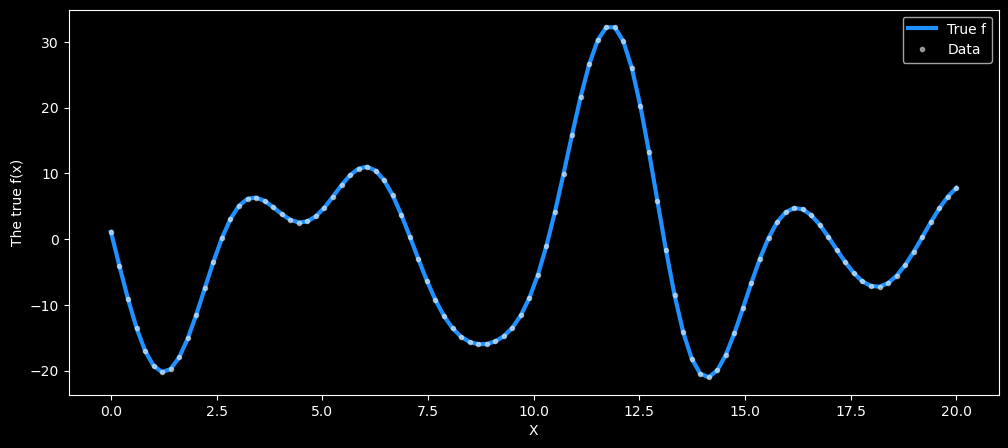

In [13]:
# set the seed
np.random.seed(1)
y = []
X = np.linspace(0, m, length)[:, None]

# Define the true covariance function and its parameters
ℓ_true1 = 3.0
ℓ_true2 = 5.0
η_true = 10.0
cov_func = η_true ** 2 * pm.gp.cov.ExpQuad(1, ℓ_true1) * pm.gp.cov.Cosine(1, ℓ_true2)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(length), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = .0
y.append(f_true + σ_true * np.random.randn(length))

# Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
plt.style.use('dark_background')
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, np.array(y).T, "ow", ms=3, alpha=0.5, label="Data", zorder=99)
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
ax.set_title('')
plt.legend();

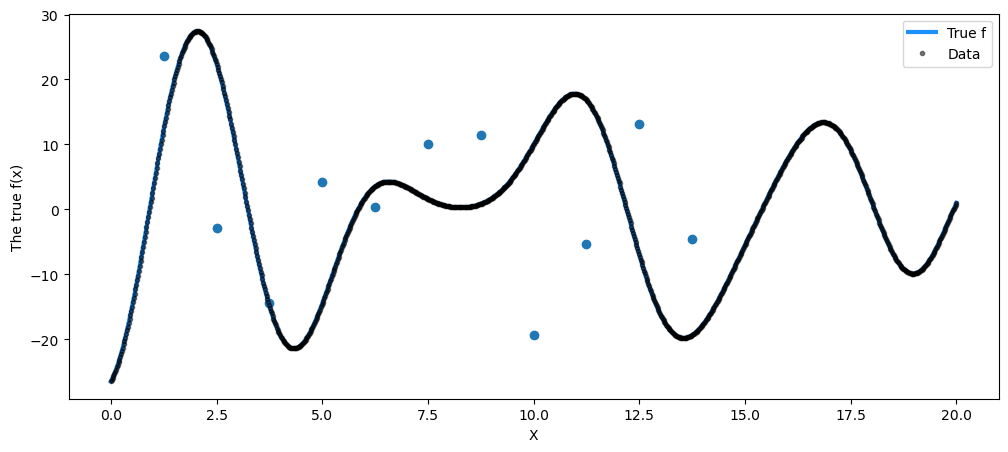

In [5]:
y_values = []

for index_list in arg:
    temp_list = []
    for i in index_list:
        temp_list.append(y[0][i])
    y_values.append(temp_list)

fig = plt.figure(figsize=(12, 5))
plt.scatter(points[10], y_values[10])
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, np.array(y).T, "ok", ms=3, alpha=0.5, label="Data", zorder=99)
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend()

In [ ]:
frames = []
for i in range(len(points)):

    with pm.Model() as model:
        X_1 = np.array(points[i])[:,None]
        l1 = pm.Normal('l1',ℓ_true1 ,.1)
        l2 = pm.Normal('l2',ℓ_true2,.1)
        η = pm.Normal('n', η_true,0.1)

        cov = η ** 2 * pm.gp.cov.ExpQuad(1, l1) * pm.gp.cov.Cosine(1,l2) # predefined covariance function
        gp = pm.gp.Marginal(cov_func=cov) # implementation of the sum of a GP prior and noise

        σ = pm.Normal("σ", σ_true, 0.1)
        y_ = gp.marginal_likelihood("y", X=X_1, y=np.array(y_values[i]), noise=σ)

        #mp = pm.find_MAP() # finds local maximimum 'a posteriori point' given a model
        tr = pm.sample(return_inferencedata=True)
    
    X_new = np.linspace(0, m, length)[:, None]
    # add the GP conditional to the model, given the new X values
    with model:
        f_pred = gp.conditional("f_pred", X_new)

    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    with model:
        pred_samples = pm.sample_posterior_predictive(tr, var_names=['f_pred'], samples=500)
        
    # plot the results
    fig = plt.figure(figsize=(12, 5))
    ax = fig.gca()

    # plot the samples from the gp posterior with samples and shading
    from pymc3.gp.util import plot_gp_dist

    plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette="Blues")

    # plot the data and the true latent function
    plt.plot(X, f_true, "r", lw=3, label="True Function", alpha=0.2)
    plt.plot(X_1, y_values[i], "or", ms=7, alpha=1, label="Training Data", zorder=99)
    # axis labels and title
    plt.xlabel("X")
    plt.ylabel('y')
    plt.xlim(0,m)
    plt.ylim([-30, 30])
    plt.title(f"Prediction with {i+1} data points")
    #plt.legend(loc="Lower right")
    
    plt.savefig(f'../Figures/img_{i}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    image = imageio.v2.imread(f'../Figures/img_{i}.png')
    frames.append(image);

In [ ]:
imageio.mimsave('../Figures/GP.gif', # output gif
                frames,          # array of input frames
                fps = 1)